# Yield Prediction using RXNBERT (SMILES)

##  Dataset Description

This dataset originates from a recent publication by a Pfizer team. Utilizing flow chemistry, they conducted a high-throughput reaction screening of the Suzuki–Miyaura C–C coupling reaction. This screening involved 11 reactants, 12 ligands, 8 bases, and 4 solvents, resulting in a total of 5760 reactions. The predictive target in this dataset is the reaction yield. (D. Perera, J. W. Tucker, S. Brahmbhatt, C. J. Helal, A. Chong, W. Farrell, P. Richardson and N. W. Sach, Science, 2018, 359, 429–434.)

The objective of this notebook is to introduce a method for predicting yiel using RXNBERT (Obtained in another notebook due to issues with environment) and non-linear model (XGBoost).

As a beginner, there may be numerous opportunities for improvement in this notebook. I was largely inspired by the work of Alexander A. Ksenofontov and co (10.1016/j.jocs.2023.102173),Jean-Louis Reymond and co (10.1039/d1dd00006c) and the André OLIVEIRA's notebook (Predicting molecule properties based on its SMILES), thanks to them.

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd 
import os 
import sys
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem
from drfp import DrfpEncoder
import shap
import cairo
import pandas as pd
import seaborn as sns
IPythonConsole.molSize = (300, 300)
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.special import boxcox1p
shap.initjs()

# DL Dataset

In [ ]:
data = r"..\data\Suzuki-Miyaura\aap9112_Data_File_S1.xlsx" # Original Dataset

dataF = pd.read_excel(data)

df_all = dataF.copy()

: 

In [7]:
data2 = r"C:\Users\loris\Desktop\finger.csv" # RXNBERT fingerprint 

dataF2 = pd.read_csv(data2)

df = dataF2.copy()

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.927183,-0.554369,-0.259487,-1.108619,1.596089,-1.421689,1.084224,0.430870,-0.021871,-0.200841,...,0.313649,0.034851,1.651640,0.279672,0.320844,-0.274366,-0.388591,1.966109,-0.234687,-1.323105
1,-0.877067,-0.606185,-0.264967,-1.143301,1.600029,-1.377390,1.078655,0.476539,0.031685,-0.133016,...,0.323120,0.007959,1.643760,0.294186,0.350441,-0.223483,-0.425070,2.023876,-0.292973,-1.354552
2,-0.974735,-0.893760,-0.253949,-1.307110,1.762661,-1.219297,1.023459,0.376712,-0.094756,-0.111835,...,0.303022,0.191766,1.819916,0.529736,0.123024,-0.229709,-0.467150,2.172896,-0.409406,-1.578342
3,-0.832605,-0.650145,-0.251956,-1.133155,1.596220,-1.341798,1.112803,0.365817,0.078370,-0.162332,...,0.341653,0.063123,1.585665,0.321065,0.283147,-0.234370,-0.349788,2.002526,-0.351226,-1.308816
4,-0.814688,-0.534443,-0.239574,-1.139217,1.556417,-1.515709,1.088360,0.486922,0.073785,-0.172098,...,0.333805,-0.044809,1.599833,0.234855,0.432300,-0.286140,-0.395744,1.952940,-0.244710,-1.262117


In [9]:
df.shape

(5760, 256)

In [11]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score
from sklearn.model_selection import train_test_split, learning_curve

In [13]:
X = df

In [14]:
X

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.927183,-0.554369,-0.259487,-1.108619,1.596089,-1.421689,1.084224,0.430870,-0.021871,-0.200841,...,0.313649,0.034851,1.651640,0.279672,0.320844,-0.274366,-0.388591,1.966109,-0.234687,-1.323105
1,-0.877067,-0.606185,-0.264967,-1.143301,1.600029,-1.377390,1.078655,0.476539,0.031685,-0.133016,...,0.323120,0.007959,1.643760,0.294186,0.350441,-0.223483,-0.425070,2.023876,-0.292973,-1.354552
2,-0.974735,-0.893760,-0.253949,-1.307110,1.762661,-1.219297,1.023459,0.376712,-0.094756,-0.111835,...,0.303022,0.191766,1.819916,0.529736,0.123024,-0.229709,-0.467150,2.172896,-0.409406,-1.578342
3,-0.832605,-0.650145,-0.251956,-1.133155,1.596220,-1.341798,1.112803,0.365817,0.078370,-0.162332,...,0.341653,0.063123,1.585665,0.321065,0.283147,-0.234370,-0.349788,2.002526,-0.351226,-1.308816
4,-0.814688,-0.534443,-0.239574,-1.139217,1.556417,-1.515709,1.088360,0.486922,0.073785,-0.172098,...,0.333805,-0.044809,1.599833,0.234855,0.432300,-0.286140,-0.395744,1.952940,-0.244710,-1.262117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,-0.729393,1.180106,-0.023760,-0.609641,1.917499,-1.405140,2.352087,1.437678,0.102846,0.742703,...,0.142657,0.669370,2.162912,0.839227,1.403204,0.574912,-1.570316,2.066997,-1.831975,-1.049428
5756,-0.607414,0.979380,0.094219,-0.655833,1.858294,-1.437959,2.452015,1.371733,0.208165,0.780290,...,0.059093,0.702316,2.266972,0.601977,1.370445,0.532155,-1.562622,2.120807,-1.971092,-1.172414
5757,-0.672274,1.114118,0.204908,-0.699272,2.133680,-1.483385,2.258699,1.532290,0.159472,0.769927,...,0.103384,0.556650,2.354824,0.659766,1.451150,0.444852,-1.598789,2.209662,-2.157221,-1.123336
5758,-0.590305,1.063587,0.115781,-0.628346,1.909117,-1.534325,2.461101,1.507404,0.196601,0.739314,...,-0.005218,0.647301,2.285167,0.620502,1.399919,0.515448,-1.514048,2.000306,-1.961360,-1.146795


In [16]:
y = df_all["Product_Yield_PCT_Area_UV"]
y = y.apply(lambda x: x/100)
y

0       0.047641
1       0.041210
2       0.025838
3       0.044432
4       0.019499
          ...   
5755    0.472114
5756    0.000000
5757    0.314437
5758    0.000000
5759    0.541974
Name: Product_Yield_PCT_Area_UV, Length: 5760, dtype: float64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4608, 256)

(1152, 256)

(4608,)

(1152,)


In [ ]:
model = XGBRegressor(
                n_estimators=200,
                learning_rate=0.01,
                max_depth=12,
                min_child_weight=6,
                colsample_bytree=0.6,
                subsample=0.8,
                random_state=42,
            )

In [20]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Squared Error:", mse)
    print("R-squared:", r2)
    print("Root Mean Squared Error:", rmse) 
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1,1,10))
    
    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='validation_score')
    plt.legend()
     

Mean Squared Error: 0.02706842275252648

R-squared: 0.6527009383643037

Root Mean Squared Error: 0.16452483931773487


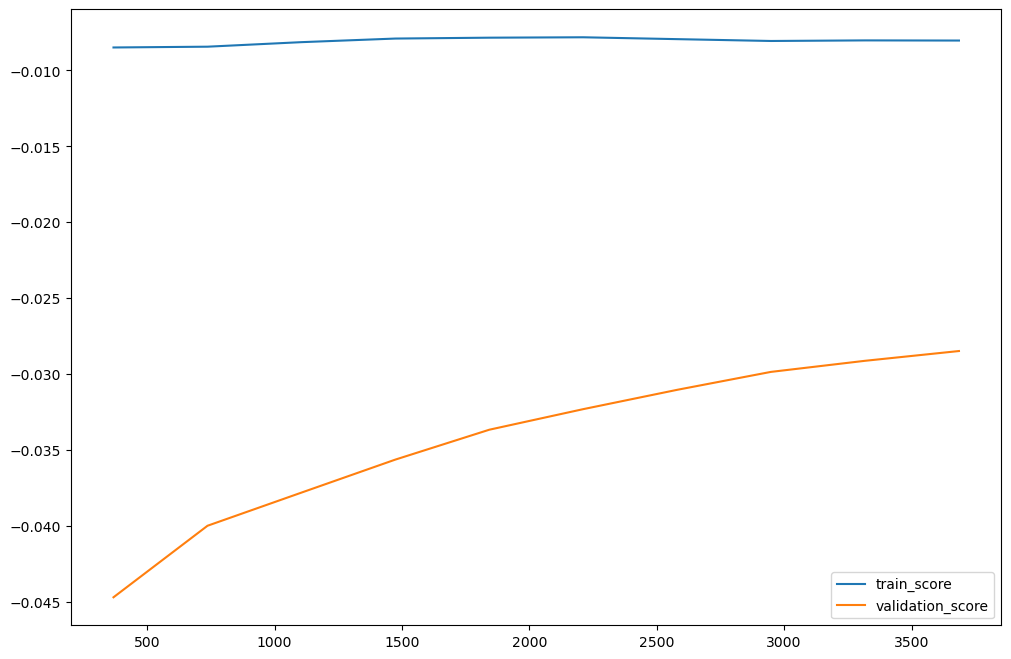

In [21]:
evaluation(model)

# Explaining Model 

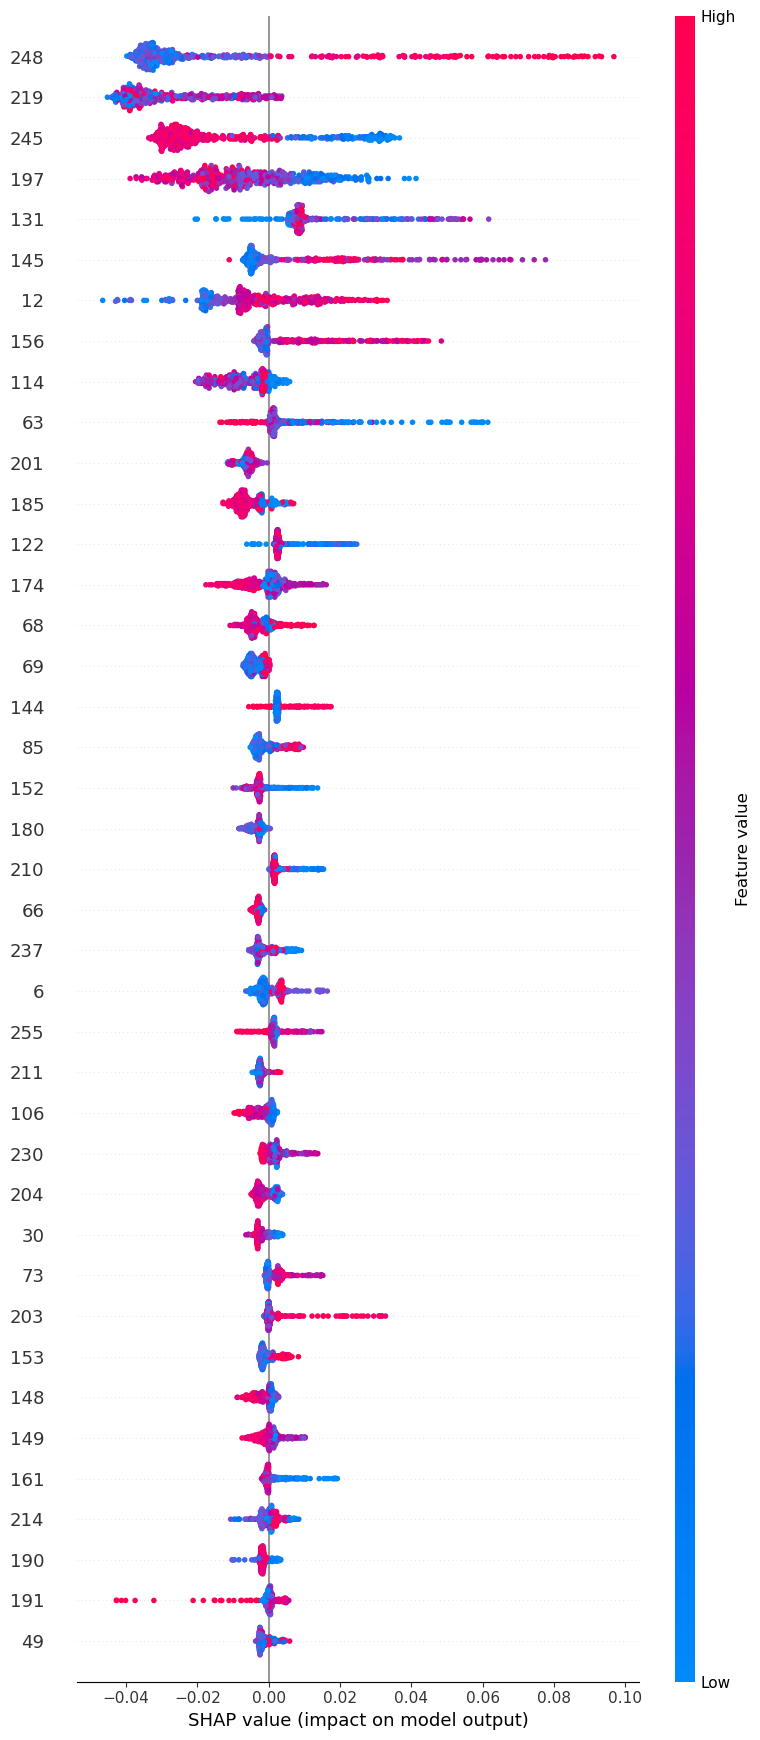

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:500])
shap.summary_plot(shap_values,X[:500] , max_display=40)

I wasn't able to represent the features from the tokenizer.
I know  that normaly RNXFP is used for classification reaction and we can draw a TMAP (https://rxn4chemistry.github.io/rxnfp/results_generate_TMAP/)